<a href="https://colab.research.google.com/github/Insight-Sogang-Univ/insight-14th/blob/template-advanced-05/advanced/template/session05/practice_languagemodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/Insight-Sogang-Univ/insight-14th/blob/main/advanced/template/session05/practice_languagemodel.ipynb" target="_parent">
      <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
  </td>
</table>


# 🔎 RAG, langchain 실습

## 관련 라이브러리 설치

* langchain 관련 라이브러리
* tavily 관련 라이브러리
* langgraph 시각화 관련 라이브러리

In [ ]:
# langchain 관련
!pip install -U langchain langchain-community langchain-openai langgraph langchain-text-splitters chromadb
# tavily 관련
!pip install -U tavily-python beautifulsoup4 lxml html5lib
# 시각화 관련
!pip install -U pydot graphviz

## Api키 값 입력

openai, tavily, langsmith api 키 값입니다!
자료 제작자 개인 계정 키 값이고, <br>유료 크레딧이기 때문에 외부 유출은 하지 마시고... 깃허브에도 올리지 말아주세요

🔗 라이브러리 링크

* openai : https://platform.openai.com/settings/organization/api-keys
  * gpt 모델들을 api로 사용하기 위한 곳
* tavily : https://www.tavily.com/
  * llm이나 agent을 위한 웹 검색 엔진 (ai 툴이랑 연동이 잘 돼요)
* langsmith : https://smith.langchain.com/
  * langchain 파이프라인을 모니터링, 추적하기 위한 곳

In [ ]:
import os

# openai api키 (원한다면 본인 계정으로 넣어도 돼요)
os.environ["OPENAI_API_KEY"] = "your-api-key"

# tavily api키 (원한다면 본인 계정으로 넣어도 돼요)
os.environ["TAVILY_API_KEY"] = "your-api-key"

# langsmith api키 (원한다면 본인 계정으로 넣어도 돼요)
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = "your-api-key"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_PROJECT"] = "practice_langgraph"



# 🍦 RAG 적용 전

In [ ]:
from openai import OpenAI
import os

# openai 클라이언트 생성
client = OpenAI()

# 📌사용자 질문 -> 원하시는 질문으로 바꿔도 됩니다!!📌
question = "2025년 롤드컵 우승팀에 대해서 설명해주세요."

# 모델 직접 호출
response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "user", "content": question}
    ],
    # temperature -> 모델의 창의성, 다양성을 조절할 수 있는 값, 허언증을 방지하기 위해 그냥 0으로 설정했어요
    temperature=0
)

print("=" * 50)
print("💡 1. RAG 적용 전 결과")
print(f"질문: {question}")
print("-" * 50)
print(response.choices[0].message.content)
print("=" * 50)

💡 1. RAG 적용 전 결과
질문: 2025년 롤드컵 우승팀에 대해서 설명해주세요.
--------------------------------------------------
죄송하지만, 2025년 롤드컵 우승팀에 대한 정보는 제공할 수 없습니다. 제 데이터는 2023년까지의 정보만 포함하고 있으며, 미래의 사건에 대한 예측이나 정보는 알 수 없습니다. 롤드컵과 같은 대회는 매년 다양한 팀들이 경쟁하므로, 결과는 그때가 되어봐야 알 수 있습니다. 롤드컵에 대한 다른 질문이나 과거의 대회에 대한 정보가 필요하시면 도와드리겠습니다!


-> gpt 4o mini 모델은 2024년 여름에 출시가 된 모델이기 때문에, 최신 정보에 대한 답변을 못하는 걸 확인할 수 있습니다!

그래서 이제 RAG를 사용해서 저희가 원하는 정보를 제대로 답변하는 모델을 만들어 볼게요!

# 📝 RAG 적용

저희는 RAG를 구축할 때, tavily라는 웹 검색 엔진을 연동해서 사용자 질문을 웹에서 검색하여 정보를 얻으려고 합니다!

간단한 구조이긴 하지만, 공부를 위해서 langchain, langgraph, langsmith까지 활용해서 답변 과정을 구성하고 모니터링까지 해보겠습니다

## 라이브러리 import

In [ ]:
from typing import TypedDict, List, Any
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter

# LLM / Embeddings
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# Search / Load / Vectorstore
from tavily import TavilyClient
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma

# Prompt & Parser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# LangGraph
from langgraph.graph import StateGraph, END


## 🟨 노드 구성 🟨

**RAGState**는 그래프 구조에 대한 스키마입니다!!<br>(말이 어렵죠? 그냥 파이프 라인에 대한 개념 정의 코드라고 생각하면 됩니다...)

<U>여러분들이 노션에서 데이터베이스 블럭을 만드는 거라고 생각하면 돼요!</U>

### 🙋🏻 노드 설명

실습에서는 6개 노드로 구성했습니다 각 노드의 역할을 알려드릴게요

* `node_search()` : **검색**
  * tavily api로 <U>url 검색</U>
* `node_load()` : **웹 문서 로드**
  * 각 url에 대해 크롤링 -> <U>'document' 형식으로 변환</U>
* `node_split()` : **청크 분할**
  * <U>'document'를 chunk 단위로 쪼개기</U>, Overlap을 적용해서 각 청크마다 겹치게 설정
* `node_index()` : **벡터 인덱스 생성**
  * 청크를 <U>임베딩 처리해서 벡터db에 저장</U> (벡터db는 chroma, 임베딩 모델은 default 모델 사용했습니다!)
* `node_retrieve()` : **유사도 검색**
  * 벡터db에서 <U>코사인 유사도를 기반으로 사용자의 질문과 유사한 정보 검색</U>, 가장 유사한 청크 4개 return
* `node_generate()` : **답변 생성**
  * return 받은 청크들로 <U>context 생성</U>, 최종적으로 언어모델에 적용하기


In [ ]:
# --------- 그래프 상태 ---------
class RAGState(TypedDict):
    question: str
    urls: List[str]
    docs: List[Document]
    chunks: List[Document]
    vectorstore: Any
    retrieved: List[Document]
    answer: str

# --------- 노드 1: 검색 (Tavily) ---------
def node_search(state: RAGState):
    print("🔎 [search] Tavily 검색 중...")
    client = TavilyClient()
    q = state["question"]

    # 웹 문서를 잡기 위해 query를 그대로, 결과 10개
    res = client.search(q, include_answer=False, max_results=10)
    urls = [item["url"] for item in res.get("results", []) if "url" in item][:10]
    print(f"  -> {len(urls)}개 URL")
    return {"urls": urls}

# --------- 노드 2: 로드 (웹 본문) ---------
def node_load(state: RAGState):
    print("🌐 [load] 웹 문서 로딩...")
    urls = state["urls"]
    docs: List[Document] = []
    for u in urls:
        try:
            loader = WebBaseLoader(u)
            loaded = loader.load()
            # 각 문서에 source 메타데이터 보강
            for d in loaded:
                d.metadata = d.metadata or {}
                d.metadata["source"] = u
            docs.extend(loaded)
        except Exception as e:
            print(f"  ! 로딩 실패: {u} ({e})")
    print(f"  -> 로딩 문서 {len(docs)}개")
    return {"docs": docs}

# --------- 노드 3: 분할 ---------
def node_split(state: RAGState):
    print("✂️  [split] 문서 분할...")
    docs = state["docs"]
    chunks = text_splitter.split_documents(docs)
    print(f"  -> 청크 {len(chunks)}개")
    return {"chunks": chunks}

# --------- 노드 4: 인덱싱 (Chroma) ---------
def node_index(state: RAGState):
    print("📦 [index] 벡터 인덱스 구성 (Chroma, 메모리)...")
    chunks = state["chunks"]
    vectordb = Chroma.from_documents(chunks, emb)
    return {"vectorstore": vectordb}

# --------- 노드 5: 검색 (Retriever) ---------
def node_retrieve(state: RAGState):
    print("📚 [retrieve] 유사 문서 검색...")
    vectordb = state["vectorstore"]
    q = state["question"]
    retriever = vectordb.as_retriever(search_kwargs={"k": 4})
    retrieved = retriever.invoke(q)
    print(f"  -> {len(retrieved)}개 문서 획득")
    return {"retrieved": retrieved}

# --------- 노드 6: 생성 (LLM) ---------
def node_generate(state: RAGState):
    print("🧪 [generate] 답변 생성...")
    q = state["question"]
    retrieved = state["retrieved"]

    # 컨텍스트 구성 (출처 명확히)
    lines = []
    for i, d in enumerate(retrieved, start=1):
        src = d.metadata.get("source", "")
        title = d.metadata.get("title", "")
        head = f"[{i}] {title or src}".strip()
        body = d.page_content
        lines.append(f"{head}\n{body}")
    context = "\n\n---\n\n".join(lines)

    chain = RAG_PROMPT | llm | StrOutputParser()
    answer = chain.invoke({"question": q, "context": context})
    print("  -> 생성 완료")
    return {"answer": answer}


## 🟨 그래프 구성 🟨

노드들을 잘 정의했으니, 이제 그래프로 구성을 하고, 언어모델도 불러와서 텍스트를 생성해보겠습니다!

📌 참고 📌

<U>그래프 구조는 맨 마지막에 langgraph 시각화로 확인할 수 있습니다</U><br>
그리고 <U>langsmith에서는 어떻게 답변이 생성됐는지 추적할 수 있어요!</U>

In [ ]:
# --------- 공용 컴포넌트 ---------
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
# 기본: text-embedding-3-small
emb = OpenAIEmbeddings()

# chunk_size랑 chunk_overlap은 임의로 900, 150으로 설정
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=900, chunk_overlap=150, separators=["\n\n", "\n", " ", ""]
)

# 모델에 적용할 프롬프트
RAG_PROMPT = ChatPromptTemplate.from_template(
    """You are a helpful expert. Answer the question ONLY using the context.
If uncertain, say you don't know. Provide a concise answer first, then list sources (title + URL).

Question: {question}

Context:
{context}
"""
)


# --------- 그래프 구성 ---------
# 노드끼리 연결하기
graph = StateGraph(RAGState)
graph.add_node("search",   node_search)
graph.add_node("load",     node_load)
graph.add_node("split",    node_split)
graph.add_node("index",    node_index)
graph.add_node("retrieve", node_retrieve)
graph.add_node("generate", node_generate)

graph.set_entry_point("search")
graph.add_edge("search",   "load")
graph.add_edge("load",     "split")
graph.add_edge("split",    "index")
graph.add_edge("index",    "retrieve")
graph.add_edge("retrieve", "generate")
graph.add_edge("generate", END)

# 그래프 컴파일
app = graph.compile()
print("✅ LangGraph compile 완료")


✅ LangGraph compile 완료


In [ ]:
question = "2025년 롤드컵 우승팀에 대해서 설명해주세요."

# 컴파일된 그래프에 질문 입력
final_state = app.invoke({"question": question})

print("\n" + "="*80)
print("📌 최종 답변")
print("="*80)
print(final_state["answer"])


🔎 [search] Tavily 검색 중...
  -> 9개 URL
🌐 [load] 웹 문서 로딩...
  -> 로딩 문서 9개
✂️  [split] 문서 분할...
  -> 청크 65개
📦 [index] 벡터 인덱스 구성 (Chroma, 메모리)...
📚 [retrieve] 유사 문서 검색...
  -> 4개 문서 획득
🧪 [generate] 답변 생성...
  -> 생성 완료

📌 최종 답변
2025년 롤드컵 우승팀은 T1입니다. T1은 KT 롤스터와의 결승에서 3-2로 승리하며 3회 연속 우승을 달성했습니다. 

Sources:
1. [롤드컵 결승] 별이 여섯 개! 월즈 쓰리핏 달성한 T1 우승 인터뷰 - https://www.inven.co.kr/news/overview/3000000000
2. [롤드컵 결승] "여기까지 온 것 만으로도 잘했다" KT 롤스터 준우승 인터뷰 - https://www.inven.co.kr/news/overview/3000000001
3. [롤드컵 결승] OPPO 파이널 MVP '구마유시' 이민형, "내가 세계 최고의 원딜" - https://www.inven.co.kr/news/overview/3000000002


🥹 답변이 저희가 원하는대로 잘 생성이 됐죠?! 출처까지 알려주니 믿을 만하네요!!

## langgraph 시각화

아까 app이라는 변수에 컴파일된 그래프를 선언했는데, 그럼 변수로 한번 그래프 구조를 직접 확인해볼까요?

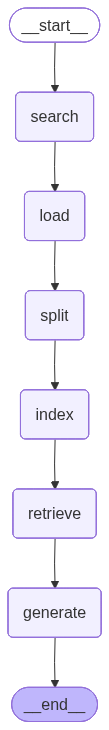

In [ ]:
app

정상적으로 선언됐다는 것을 확인할 수 있습니다!!

과제에서는 웹 검색 기반이 아닌, 여러분들이 직접 pdf를 입력해서 답변을 생성하는 코드를 다룰 예정입니다! 다들 많관부~~

## langsmith

사실 아까 위해서 api 값 선언하는 코드 중에 그냥 넘어간 부분이 있는데, 해당 코드 중에서 langsmith 관련 내용이 있습니다

계정 api키를 입력하고 project 이름을 설정하고 langsmith 사이트에 들어가면, 추적을 할 수 있을거에요!

스스로 직접 확인하고 싶으면, langsmith 계정 만들고 설정값을 입력하시면 됩니다.

```
import os

# langsmith api키 (원한다면 본인 계정으로 넣어도 돼요)
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = "랭스미스 키 값 입력하기"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_PROJECT"] = "프로젝트명"
```